## **1. Overview**

*MaxCorr* is a python package for the estimation of Maximal (Non-Linear) Correlations in sets of bivariate and multivariate data.

The package includes:
* **3** indicator semantics (`'hgr'`, `'gedi'`, and `'nlc'`);
* **6** estimation algorithms (`'dk'`, `'sk'`, `'nn'`, `'lat'`, `'kde'`, `'rdc'`);
* **3** backends for numerical operations (`'numpy'`, `'torch'`, `'tensorflow'`).

Indicators can be built using the main function `maxcorr.indicator`, specifying these three options.
Eventually, the correlation can be computed using the method `compute(a, b)` method, passing the inputs vectors/matrices as parameters.

In [1]:
import numpy as np
from maxcorr import indicator

rng = np.random.default_rng(0)
a = rng.normal(loc=3.0, scale=2.0, size=100)
b = rng.normal(loc=2.0, scale=5.0, size=100)

ind = indicator(semantics='hgr', algorithm='dk', backend='numpy')
ind.compute(a, b)

0.27853871103466216

## **2. Semantics**

The default semantics is HGR, which stands for ***Hirschfield-Gebelin-Rényi*** correlation coefficient.

When no parameter is passed to the `indicator` function, the returned indicator automatically assumes the HGR semantics.

In [2]:
ind = indicator()
print(f"Default Semantics: '{ind.semantics}'")

Default Semantics: 'hgr'


More specifically, the Hirschfield-Gebelin-Rényi coefficient ([Rényi, 1959](https://static.Rényi.hu/Rényi_cikkek/1959_on_measures_of_dependence.pdf)) is a non-linear correlation coefficient based on Pearson's correlation.
It is defined as the maximal correlation that can be achieved by transforming two random variables ($A, B$) into non-linear domains through two copula transformations, i.e.:

$$\text{HGR}(A, B) = \sup_{f \in \mathcal{F}, g \in \mathcal{F}} \frac{\text{cov}(f_A, g_B)}{\sigma(f_A) \cdot \sigma(f_B)}$$

where $f_A = f(A)$ and $g_B = g(B)$ are the two copula transformations belong to the Hilbert $\mathcal{F}$ space of all possible mapping functions.
Although HGR is proved to be uncomputable, many different estimation algorithms have been proposed in the literature, some of which are implemented in this package.

In [3]:
hgr = indicator(semantics='hgr')
print('HGR:', hgr.compute(a, b))

HGR: 0.27853871103466216


Another available semantics is the Generalized Disparate Impact, or ***GeDI*** ([Giuliani et al., 2023](https://proceedings.mlr.press/v202/giuliani23a/giuliani23a.pdf)). It is a non-linear correlation coefficient which extends the concept of Disparate Impact ([Aghaei et al., 2019](https://dl.acm.org/doi/pdf/10.1609/aaai.v33i01.33011418)) defined in the field of algorithmic fairness and whose value is computed as the ratio between the covariance of the two variables $A$ and $B$ and the variance of $A$ – also known as $\beta$ coefficient in statistics and finance.
Although the original definition of the indicator from _Giuliani et al._ is specific to their proposed estimation approach, here we use a slight variation in order to link it to HGR and make it computable by all our implemented algorithms.
Formally, we define GeDI as:

$$\text{GeDI}(A, B) = \sup_{f \in \mathcal{F}, g \in \mathcal{F}} \frac{\text{cov}(f_A, g_B)}{\sigma(f_A)^2} \quad \text{s.t.} \quad \sigma(f_A) = \sigma(A), \quad \sigma(g_B) = \sigma(B)$$

namely we bound the two copula transformation to maintain the same standard deviation of the original random variables in order to avoid the explosion of the indicator by means of a simple rescaling of the mapping functions.
Since HGR is based on Pearson's correlation, hence it is scale invariant, this aspect was not problematic in its definition; however, this also allows us to redefine HGR by imposing the same constraints used in GeDI without loss of generality, i.e.:

$$\text{HGR}(A, B) = \sup_{f \in \mathcal{F}, g \in \mathcal{F}} \frac{\text{cov}(f_A, g_B)}{\sigma(f_A) \cdot \sigma(g_B)} \quad \text{s.t.} \quad \sigma(f_A) = \sigma(A), \quad \sigma(g_B) = \sigma(B)$$

making GeDI equivalent to HGR up to a scaling factor which depends on the standard deviation of the original random variables, i.e.:

$$\text{GeDI}(A, B) = \text{HGR}(A, B) \cdot \frac{\sigma(B)}{\sigma(A)}$$

In [4]:
gedi = indicator(semantics='gedi')
print('GeDI:', gedi.compute(a, b), '≈', hgr.compute(a, b).round(2), '*', b.std(ddof=0).round(2) , '/', a.std(ddof=0).round(2))

GeDI: 0.6916942160379445 ≈ 0.28 * 4.78 / 1.92


Finally, the third indicator is the Non-Linear Covariance (***NLC***).
It a non-linear extension of the covariance measure that comes naturally after the definition of the first two semantics which, by leveraging the same constraints used in GeDI, is defined as:

$$\text{NLC}(A, B) = \sup_{f \in \mathcal{F}, g \in \mathcal{F}} \text{cov}(f_A, g_B) \quad \text{s.t.} \quad \sigma(f_A) = \sigma(A), \quad \sigma(g_B) = \sigma(B)$$

Therefore, by adopting the same strategy used before, we have that NLC is also equivalent to HGR up to a scaling factor, i.e.:

$$\text{NLC}(A, B) = \text{HGR}(A, B) \cdot \sigma(A) \cdot \sigma(B)$$

In [5]:
nlc = indicator(semantics='nlc')
print('NLC:', nlc.compute(a, b), '≈', hgr.compute(a, b).round(2), '*', b.std(ddof=0).round(2) , '*', a.std(ddof=0).round(2))

NLC: 2.561191576285819 ≈ 0.28 * 4.78 * 1.92


## **3. Algorithms**

The default choice when calling the `indicator` function is Double Kernel (`'dk'`).

In [6]:
ind = indicator()
print(f"Default Algorithm: '{ind.algorithm}'")

Default Algorithm: 'dk'


However, there are in total six estimation techniques, which can be invoked with their respective keywords (`'dk'`, `'sk'`, `'nn'`, `'lat'`, `'kde'`, `'rdc'`) and work as follows:

[**Double Kernel**]
This algorithm is inspired by the one proposed by [Giuliani et al. (2023)](https://proceedings.mlr.press/v202/giuliani23a/giuliani23a.pdf) for the computation of the Generalized Disparate Impact, and extended to account for HGR computation as well.
Given two vectors $a$ and $b$, the core idea is to build two kernel matrices $F_a = [f_1(a), ..., f_h(a)]$ and $G_b = [g_1(b), ... g_k(b)]$ based on a set of user-defined functions.
The copula transformations $f$ and $g$ are then represented as the matrix product $F_a \cdot \alpha$ and $G_b \cdot \beta$, respectively, where $\alpha$ and $\beta$ are two vectors of mixing coefficients.
Eventually, the algorithm then uses global optimization techniques to find the optimal coefficient vectors resulting in the maximal correlation.

[**Single Kernel**]
This is a variant of the previous algorithm which allows to account for functional dependencies only, although in either directions.
Formally, given a set of functions $f_1, ..., f_d$, tests the correlation between $[f_1(a), ..., f_d(a)] \cdot \alpha$ and $b$, and between $a$ and $[f_1(b), ..., f_d(b)] \cdot \beta$, eventually taking the maximal value.
Again, if no mapping functions are specified, the indicator uses polynomial kernel expansions.

[**Neural**]
This approach was proposed by [Grari et al. (2020)](https://www.ijcai.org/proceedings/2020/0313.pdf) and models the two copula transformation $f$ and $g$ as two neural networks.

[**Lattice**]
This is a custom variant of Grari et al.'s approach which uses Lattice Models to approximate the two copula transformation.

[**Density**]
This approach was proposed by [Mary et al. (2019)](https://proceedings.mlr.press/v97/mary19a/mary19a.pdf) and computes the maximal correlation using a theoretical upper-bound of HGR known as Witsenhausen's characterization ([Witsenhausen, 1975](https://www.jstor.org/stable/pdf/2100465.pdf)).

[**Randomized**]
This approach was proposed by [Lopez-Paz et al. (2013)](https://papers.nips.cc/paper_files/paper/2013/file/aab3238922bcc25a6f606eb525ffdc56-Paper.pdf) and computes the maximal correlation by mapping the input vectors $a$ and $b$ with a set of randomly-calibrated sinusoidal functions.
Eventually, the pair of functions returning the highest correlation is selected using Canonical Correlation Analysis (CCA).

In [7]:
algorithms = ['dk', 'sk', 'nn', 'lat', 'kde', 'rdc']
for i, algorithm in enumerate(algorithms):
    ind = indicator(algorithm=algorithm)
    print(f'{i + 1}. {ind.__class__.__name__}')

1. DoubleKernelIndicator
2. SingleKernelIndicator
3. NeuralIndicator
4. LatticeIndicator
5. DensityIndicator
6. RandomizedIndicator


Algorithms might have specific parameters that can be passed as keyword arguments to the `indicator` function.
For example:
* the Double Kernel algorithm can take the specifics of the two kernels, which is either a callable function or an integer representing the degree of the polynomial expansion;
* the Neural algorithm takes the number of hidden units in the neural transformations, or None for no transformation;
* the Randomized algorithm takes the number of random projections to test.

In [8]:
dk = indicator(algorithm='dk', kernel_a=5, kernel_b=1)
nn = indicator(algorithm='nn', f_units=(8, 8, 8), g_units=None)
rdc = indicator(algorithm='rdc', projections=10)

Alternatively, it is possible to create a specific instance of each indicator by calling the constructor method of each respective class.
The constructor methods explicitly asks for specific indicator parameters.

In [9]:
from maxcorr.indicators import DoubleKernelIndicator, SingleKernelIndicator, NeuralIndicator, LatticeIndicator, DensityIndicator, RandomizedIndicator

print('Indicator Constructors:')
for cls in [DoubleKernelIndicator, SingleKernelIndicator, NeuralIndicator, LatticeIndicator, DensityIndicator, RandomizedIndicator]:
    params = ', '.join(cls.__init__.__annotations__)
    print(f'> {cls.__name__}({params})')
    
dk = DoubleKernelIndicator(kernel_a=5, kernel_b=1)
nn = NeuralIndicator(f_units=(8, 8, 8), g_units=None)
rdc = RandomizedIndicator(projections=10)

Indicator Constructors:
> DoubleKernelIndicator(kernel_a, kernel_b, backend, semantics, method, maxiter, eps, tol, use_lstsq, delta_independent)
> SingleKernelIndicator(kernel, backend, semantics, method, maxiter, eps, tol, use_lstsq, delta_independent)
> NeuralIndicator(f_units, g_units, backend, semantics, num_features, epochs_start, epochs_successive, learning_rate, eps)
> LatticeIndicator(f_sizes, g_sizes, backend, semantics, epochs_start, epochs_successive, learning_rate, eps, f_kwargs, g_kwargs)
> DensityIndicator(backend, semantics, chi_square, damping)
> RandomizedIndicator(functions, backend, semantics, projections, scale, repetitions)


Other than their parameters, algorithms differ in their estimation capabilities, required computational time, differentiability, and additional properties. Here, we perform a simple comparison of the computational times required to compute the correlation between $a$ and $b$.

100%|██████████| 180/180 [00:12<00:00, 13.89it/s]


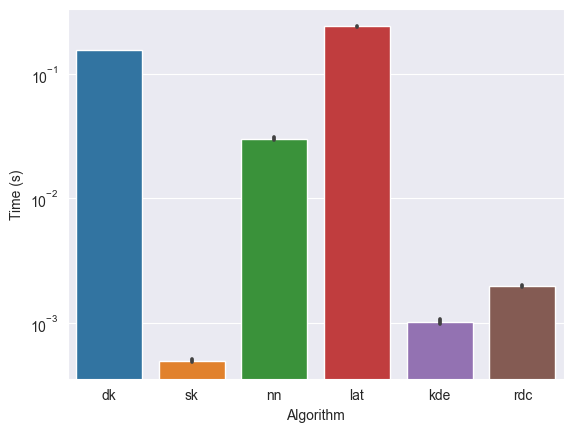

In [10]:
import pandas as pd
import seaborn as sns
import time
import tqdm

results = []
pbar = tqdm.tqdm(total=30 * len(algorithms))
for repetition in range(30):
    for algorithm in algorithms:
        start = time.time()
        indicator(algorithm=algorithm, semantics='hgr', backend='numpy').compute(a=a, b=b)
        results.append({'Algorithm': algorithm, 'Repetition': repetition, 'Time (s)': time.time() - start})
        pbar.update(1)
pbar.close()

results = pd.DataFrame(results)
ax = sns.barplot(results, x='Algorithm', y='Time (s)')
ax.set_yscale('log')

## **4. Backend**

The default choice when calling the `indicator` function is the `'numpy'` backend.

In [11]:
ind = indicator()
print(f"Default Backend: '{ind.backend.name}'")

Default Backend: 'numpy'


In addition to that, the other available backends are `'torch'` and `'tensorflow'`.

Choosing one backend with respect to another mainly depends on the type of input data and available hardware, but most importantly on whether the result should contain ***gradient information*** or not.
While numpy does not keep track of gradients, torch and tensorflow do, and this information can be exploited to enforce specific correlations during the training of neural networks using the indicator results as a loss regularizer.

In [12]:
import torch

a_torch = torch.tensor(a, requires_grad=True)
b_torch = torch.tensor(b, requires_grad=True)
indicator(algorithm='dk', backend='torch').compute(a_torch, b_torch)

tensor(0.2785, grad_fn=<MulBackward0>)

Notice that we had to cast the input vectors as torch vectors in order to keep track of the gradients.
In fact, the `compute` method expects inputs to comply to the backend, otherwise it will not be able to keep track of the gradients.

In [13]:
indicator(algorithm='dk', backend='torch').compute(a, b)

tensor(0.2785)

Moreover, in order for a backend to work properly, packages must be installed in the local machine/virtual environment.
This can be done by passing optional dependencies within square brackets when installing _MaxCorr_ via pip, e.g.:
```
pip install maxcorr[torch,tensorflow,lattice,full]
```

Take into consideration that, although each algorithm can work with each backend, this is somehow due to cast mechanisms going on under the hood, hence they might not be able to yield a gradient.
In particular:
* *Double Kernel* and *Single Kernel* algorithms can work natively with any backend and do not require additional dependencies unless that of the selected backend;
* The *Neural* algorithm is compatible with both torch and tensorflow, but requires either of the two dependencies to perform the neural computation even in case the `'numpy'` backend is selected;
* The *Lattice* algorithm is compatible with tensorflow only, and requires both `tensorflow` and `tensorflow-lattice` to be installed;
* The *Density* algorithm is compatible with torch only, and it requires its dependency;
* The *Randomized* algorithm does not yield any gradient by definition, but it does not need any additional dependency to work.

For example, if we try to compute correlation using the lattice indicator with `'torch'` backend, the result will not have gradient information as it will be a constant vector obtained by casting the tensorflow result.

In [14]:
indicator(algorithm='lat', backend='torch').compute(a_torch, b_torch)

tensor(0.4004)

## **5. Additional Operations**

In certain application scenarios, some additional operations might be useful other than the mere computation of correlation.
Here, we will show three of them using a Double Kernel indicator as an example.


In [15]:
ind = DoubleKernelIndicator(kernel_a=3, kernel_b=2, semantics='hgr', backend='numpy')

#### ***5.1. Results Metadata***

By invoking the `compute` method, the obtained result is simply the correlation value in the chosen backend.
Nonetheless, additional information are stored into a `Result` object, which is returned by directly calling the indicator object itself.

Each algorithm returns at least the following metadata:
* `num_call`, an integer representing how many times that specific indicator instance has been called;
* `indicator`, which contains a reference to the indicator instance that generated the result;
* `value`, that is the actual correlation value;
* `a`, i.e., a copy of the input vector $a$;
* `b`, i.e., a copy of the input vector $b$.

Moreover, specific algorithms may include additional specific information.
For example, each `Result` object returned by a Double Kernel instance also returns the optimal coefficients $\alpha$ and $\beta$.

In [16]:
result = ind(a, b)
print('>        Call Number:', result.num_call)
print('>  Calling Indicator:', result.indicator)
print('>  Correlation Value:', result.value)
print('>  Vector <a>, Shape:', result.a.shape)
print('>  Vector <b>, Shape:', result.b.shape)
print('>  Beta Coefficients:', result.beta)
print('> Alpha Coefficients:', result.alpha)

>        Call Number: 1
>  Calling Indicator: Indicator(semantics='hgr', algorithm='dk', backend='numpy')
>  Correlation Value: 0.2653533889633538
>  Vector <a>, Shape: (100,)
>  Vector <b>, Shape: (100,)
>  Beta Coefficients: [0.6451657317178631, 0.35483426828213693]
> Alpha Coefficients: [-0.22975995421273554, 0.6753083630949782, -0.09493168269228616]


The `Result` object can be also accessed from the indicator instance using the property `last_result`.
In this case, even by calling the `compute` method, we can eventually access all the additional information.

In [17]:
ind.compute(a, b)
print('>        Call Number:', ind.last_result.num_call)
print('>  Calling Indicator:', ind.last_result.indicator)
print('>  Correlation Value:', ind.last_result.value)
print('>  Vector <a>, Shape:', ind.last_result.a.shape)
print('>  Vector <b>, Shape:', ind.last_result.b.shape)
print('>  Beta Coefficients:', ind.last_result.beta)
print('> Alpha Coefficients:', ind.last_result.alpha)

>        Call Number: 2
>  Calling Indicator: Indicator(semantics='hgr', algorithm='dk', backend='numpy')
>  Correlation Value: 0.265353388963351
>  Vector <a>, Shape: (100,)
>  Vector <b>, Shape: (100,)
>  Beta Coefficients: [0.6451660853295247, 0.35483391467047537]
> Alpha Coefficients: [-0.2297604559463598, 0.6753079345612953, -0.09493160949234487]


Notice how, this time, the call number is different.
In fact, by calling the `compute` method we run the optimization algorithm again, which generated a new `Result` object different from the previous one. 

Although the Double Kernel algorithm is deterministic, and we used the same input vectors, some of the remaining fields are also different.
The reason is that **invoking the estimation algorithm twice using the same indicator instance is different from calling it twice using two different indicator instances**, because each instance can keep track of previous states in order to use warm starting techniques.

For example, when called for the $n^{th}$ time, the Double Kernel indicator uses the coefficients $[\alpha_{n-1}, \beta_{n-1}]$ as initial guess for the optimization algorithm.
Similarly, the Neural indicator uses a pre-training strategy where the neural networks are trained for $E$ epochs at the first call, while in the subsequent calls the pre-trained networks are fine-tuned for a number of epochs $e < E$.
These aspects are particularly useful to speed up the computation when the correlation value is used as a loss regularizer in the context of constrained machine learning, where the same correlation indicator has to be computed many times for a number of slightly different input vectors.
It is therefore important that, **when two different computations involve two different or unrelated sets of vectors, the correlations are computed using two different indicator instances rather than one called two times**.

As an example, see how invoking the computation on an indicator which was previously used for completely different vectors results in a small underestimation of the correlation due to the use of wrong initialization coefficients in the second call.

In [18]:
rng = np.random.default_rng(1)
x = rng.beta(a=10, b=0.5, size=100)
y = rng.beta(a=90, b=0.2, size=100)

ind1 = DoubleKernelIndicator(kernel_a=7, kernel_b=7, semantics='hgr', backend='numpy')
ind2 = DoubleKernelIndicator(kernel_a=7, kernel_b=7, semantics='hgr', backend='numpy')

ind1.compute(a, b)
print('> HGR(x, y) using Second Call of First Indicator:', ind1.compute(x, y))
print('> HGR(x, y) using First Call of Second Indicator:', ind2.compute(x, y))

> HGR(x, y) using Second Call of First Indicator: 0.28910443369702515
> HGR(x, y) using First Call of Second Indicator: 0.29041150085375034


Finally, each indicator also keeps track of how many times the estimation algorithm is called.
At the beginning, this number is zero, and trying to access the `last_result` property will return nothing.

In [19]:
new_ind = DoubleKernelIndicator(kernel_a=3, kernel_b=2, semantics='hgr', backend='numpy')
print('New Indicator -->  Num Calls  =', new_ind.num_calls)
print('New Indicator --> Last Result =', new_ind.last_result)

New Indicator -->  Num Calls  = 0
New Indicator --> Last Result = None


#### ***5.2. Inspection of Copula Transformations***

Some algorithms provide access to the learned copula transformations, which can be later inspected both on the same and on different data.
These are the Double and Single Kernel, the Neural, and the Lattice algorithms.

The copula transformation can be accessed using the `f` and `g` methods, which take a vector as input.
This feature allows to plot the learned functions and see the type of relationship that exists between the two input vectors.

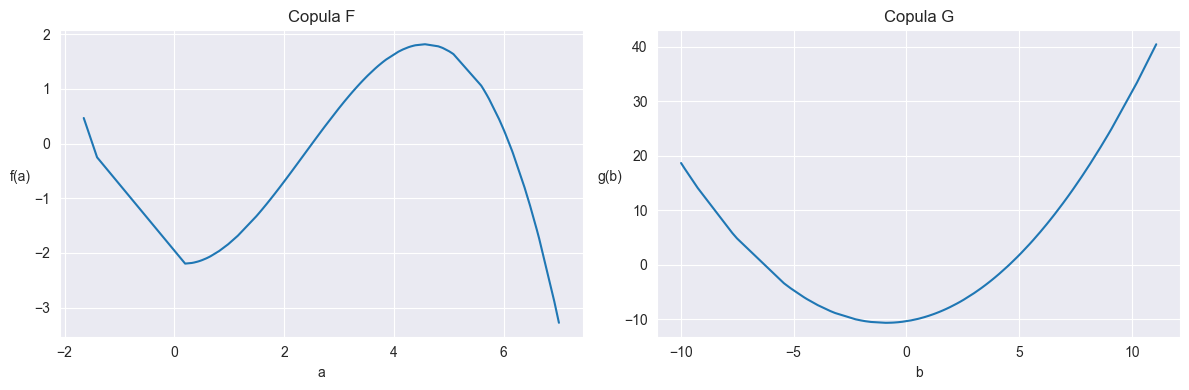

In [20]:
import matplotlib.pyplot as plt

fa = ind.f(a)
gb = ind.g(b)

_, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4), tight_layout=True)
axes[0].plot(*zip(*sorted(zip(a, fa))))
axes[0].set_xlabel('a')
axes[0].set_ylabel('f(a)', rotation=0, labelpad=10)
axes[0].set_title('Copula F')
axes[1].plot(*zip(*sorted(zip(b, gb))))
axes[1].set_xlabel('b')
axes[1].set_ylabel('g(b)', rotation=0, labelpad=10)
axes[1].set_title('Copula G');

Copula transformations are also useful to validate the obtained results against the risk of overfitting.
In fact, if a test dataset $(a_t, b_t)$ is available, we can compute the indicator using the projections $f_t = f(a_t)$ and $g_t = g(b_t)$ obtained using tha available transformations without any optimization involved.
If we see that the resulting value is much lower than the one obtained during the optimization using the training data, then it is likely that the estimation algorithm is overfitting on that data.

The computation of the indicator on test data can be either done manually by invoking the `f` and `g` methods to get the projections, or via the `value` method which computes the indicator value on two vectors without performing any optimization (differently from the `compute` method which calls the estimation algorithm).

In [21]:
rng = np.random.default_rng(2)
a_test = rng.normal(loc=3.0, scale=2.0, size=100)
b_test = rng.normal(loc=2.0, scale=5.0, size=100)

cov = np.cov(fa, gb, ddof=0)
value = cov[0, 1] / np.sqrt(cov[0, 0] * cov[1, 1])

fa_test = ind.f(a_test)
gb_test = ind.g(b_test)
cov_test = np.cov(fa_test, gb_test, ddof=0)
value_test = cov_test[0, 1] / np.sqrt(cov_test[0, 0] * cov_test[1, 1])

print('> Train Correlation (from results):', ind.last_result.value)
print('> Train Correlation (using copula):', value)
print('> Train Correlation (using method):', ind.value(a, b))
print()
print('>  Test Correlation (using copula):', value_test)
print('>  Test Correlation (using method):', ind.value(a_test, b_test))

> Train Correlation (from results): 0.265353388963351
> Train Correlation (using copula): 0.26535339098030736
> Train Correlation (using method): 0.26535339091014826

>  Test Correlation (using copula): 0.13337136810861897
>  Test Correlation (using method): 0.13337136808148137


Here, for example, we see that the test correlation is halved with respect to the train one, suggesting some degree of overfitting in the estimation procedure. 
Also, notice that the `value` method does not change the last results, nor increases the number of calls of the indicator instance.

In [22]:
print('Last Value:', ind.last_result.value)
print(' Num Calls:', ind.num_calls)

Last Value: 0.265353388963351
 Num Calls: 2


#### ***5.3. Multivariate Correlations***

Finally, we mention that the same algorithms that allow for the inspection of copula transformations can also handle multivariate data.
This can be done by passing a matrix rather than a vector for either $a$ or $b$ (or both), and optionally specifying additional information in the indicator's constructor.

Keeping the example of the Double Kernel indicator, it can automatically build a polynomial expansion kernel of more variables without the need to specify any additional parameter.
For example, given the inputs $a = [a_1, a_2]$ and $b = [b_1, b_2, b_3]$, with respective degrees $h = 3$ and $k = 2$, the polynomial expansions will be:

$$f(a) = [a_1, a_2, a_1^2, a_1 \cdot a_2, a_2^2, a_1^3, a_1^2 \cdot a_2, a_1 \cdot a_2^2, a_2^3]$$
$$g(b) = [b_1, b_2, b_3, b_1^2, b_1 \cdot b_2, b_1 \cdot b_3, b_2^2, b_2 \cdot b_3, b_3^2]$$

In [23]:
rng = np.random.default_rng(3)
a_multi = rng.normal(loc=3.0, scale=2.0, size=(100, 2))
b_multi = rng.normal(loc=2.0, scale=5.0, size=(100, 3))

ind = DoubleKernelIndicator(kernel_a=3, kernel_b=2, semantics='hgr', backend='numpy')
res = ind(a_multi, b_multi)
print('> Correlation:', res.value)
print('>       Alpha:', np.round(res.alpha, 2))
print('>        Beta:', np.round(res.beta, 2))

> Correlation: 0.5244499726952101
>       Alpha: [ 0.3  -0.42 -0.05 -0.02  0.16  0.    0.01 -0.02 -0.01]
>        Beta: [ 0.25  0.4   0.23  0.   -0.03  0.03 -0.04 -0.01 -0.01]


The same goes for the Single Kernel indicator, while the Neural and the Lattice ones require the input sizes to be specified in the indicator constructor.
In particular:
* the Neural indicator takes an input argument with default value `num_features = (1, 1)` which indicates the number of input features for the $a$ and $b$ vectors, respectively;
* the Lattice indicator takes two input arguments with default value `f_sizes=(10,)` `g_sizes=(10,)` which indicates the number of keypoints used for each input feature.

In [24]:
ind_nn = NeuralIndicator(num_features=(2, 3), f_units=(8, 8, 8), g_units=(8, 8, 8), semantics='hgr', backend='numpy')
print('>  Neural Correlation:', ind_nn.compute(a_multi, b_multi))

ind_lat = LatticeIndicator(f_sizes=(5, 5), g_sizes=(5, 5, 5), semantics='hgr', backend='numpy')
print('> Lattice Correlation:', ind_lat.compute(a_multi, b_multi))

>  Neural Correlation: 0.4160856306552887
> Lattice Correlation: 0.802560567855835
